# ECG Linear Classification Training

This notebook implements logistic regression for ECG age group classification with:

- **Feature selection**: SelectKBest with ANOVA F-test
- **Class imbalance handling**: SMOTE oversampling
- **Hyperparameter tuning**: GridSearchCV
- **Comprehensive evaluation**: Multiple metrics and visualizations

## Table of Contents
1. [Data Loading](#data-loading)
2. [Data Preprocessing](#data-preprocessing)
3. [Feature Selection](#feature-selection)
4. [Hyperparameter Tuning](#hyperparameter-tuning)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)
7. [Visualization and Analysis](#visualization-and-analysis)


## 1. Data Loading

Load ECG features from CSV and set up the environment.


In [9]:
# Import required libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")  # keep output tidy; remove if debugging

# Configuration
CSV_FILE = "/Users/dmytro/Diploma/ecg_ml_analysis/v2/output/ecg_features.csv"   # change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.2
OUTPUT_DIR = "./ecg_linear_outputs"
OUTPUT_PNG = os.path.join(OUTPUT_DIR, "all_plots.png")
K_FEATURES = 20   # choose at least 10 features (user requested min 10)
SMOTE_K_NEIGHBORS = 3

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✅ Environment setup completed")


✅ Environment setup completed


In [10]:
# Load data
print("Loading:", CSV_FILE)
data = pd.read_csv(CSV_FILE)
print("Shape:", data.shape)

# If 'record' column exists but isn't needed, keep it aside (not used as feature)
if "record" in data.columns:
    record_col = data["record"]
else:
    record_col = None

print("✅ Data loaded successfully")
data.head(10)

Loading: /Users/dmytro/Diploma/ecg_ml_analysis/v2/output/ecg_features.csv
Shape: (1120, 29)
✅ Data loaded successfully


,mean,std,min,max,median,skew,kurtosis,hr_mean,hr_std,rmssd,...,pca_ratio_1,pca_ratio_2,record,age_group,gender,device,corr_ch0_ch2,cov_ch0_ch2,corr_ch1_ch2,cov_ch1_ch2
0,5.000000e+00,0.103834,4.736477,5.667927,4.978795,3.534223,16.788716,39.433108,1.277873,0.016022,...,0.000000,0.0,483,2.0,1.0,1.0,NaN,NaN,NaN,NaN
1,1.156490e-17,0.143917,-0.620451,1.043088,-0.046955,-116.966317,30872.227666,23.574785,2.811981,0.067057,...,0.000018,0.0,497,2.0,1.0,1.0,NaN,NaN,NaN,NaN
2,3.333333e+00,0.090217,2.985992,4.039514,3.310691,2.828664,19.366225,29.191409,4.203380,0.066057,...,0.056653,0.0,1038,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-5.000000e+00,0.044118,-5.131624,-4.643481,-5.010116,4.892410,28.992977,30.258378,2.763537,0.045106,...,0.000000,0.0,326,2.0,1.0,1.0,NaN,NaN,NaN,NaN
4,-5.000000e+00,0.092562,-5.752685,-4.260004,-5.030029,4.252412,21.278652,32.180474,2.490244,0.037237,...,0.000000,0.0,440,2.0,1.0,1.0,NaN,NaN,NaN,NaN
5,3.333333e+00,0.116059,2.931765,4.098617,3.301733,2.871457,13.663969,46.186859,1.697614,0.022620,...,0.063104,0.0,454,2.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.333333e+00,0.485164,-3.981842,5.904980,3.333901,-0.737600,29.248471,81.059433,5.032032,0.113078,...,0.000856,0.0,332,4.0,0.0,0.0,0.0,0.0,0.0,0.0
7,5.000000e+00,0.240395,4.817800,6.374306,4.929390,3.996398,15.992554,47.781628,0.835803,0.004708,...,0.000000,0.0,1004,3.0,0.0,1.0,NaN,NaN,NaN,NaN
8,3.333333e+00,0.128013,2.849605,4.076728,3.289854,1.709589,9.077898,43.856281,2.780303,0.028207,...,0.177147,0.0,468,6.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.333333e+00,0.083633,2.891642,3.926245,3.310332,3.310508,14.396552,39.719118,2.781602,0.039056,...,0.135892,0.0,1010,6.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data Preprocessing

Handle missing values and filter features.


In [5]:
# Preprocess missing values
# Fill missing values with the least common (mode-like but least frequent) within column as in baseline
from collections import Counter as _Counter
for col in data.columns:
    if data[col].isnull().any():
        counts = _Counter(data[col].dropna())
        if counts:
            least_common_value = counts.most_common()[-1][0]
            data[col].fillna(least_common_value, inplace=True)

# Feature filtering
# Remove explicit non-feature columns if present
drop_cols = {"record", "age_group", "gender", "device"}
available_cols = [c for c in data.columns if c not in drop_cols]

# Drop columns with more than 30% missing values (fallback; should be none after fill, but keep for safety)
threshold = 0.3 * len(data)
valid_features = [c for c in available_cols if data[c].count() >= threshold]

# Remove features with extremely small magnitude (mean absolute < 1e-6)
filtered_features = [c for c in valid_features if np.nanmean(np.abs(data[c])) > 1e-6]

# Remove zero-variance features
filtered_features = [c for c in filtered_features if data[c].nunique() > 1]

print(f"Candidate features after filtering: {len(filtered_features)}")
print(filtered_features)

# Target
if "age_group" not in data.columns:
    raise RuntimeError("CSV must contain 'age_group' column")
y = data["age_group"].astype(int)

print("✅ Data preprocessing completed")


Candidate features after filtering: 25
['mean', 'std', 'min', 'max', 'median', 'skew', 'kurtosis', 'hr_mean', 'hr_std', 'rmssd', 'nn50', 'pnn50', 'VLF', 'LF', 'HF', 'LFHF', 'corr_ch0_ch1', 'cov_ch0_ch1', 'pca_ratio_0', 'pca_ratio_1', 'pca_ratio_2', 'corr_ch0_ch2', 'cov_ch0_ch2', 'corr_ch1_ch2', 'cov_ch1_ch2']
✅ Data preprocessing completed


## 3. Feature Selection

Select top-K features using SelectKBest with ANOVA F-test.


In [6]:
# Select top-K features
X_all = data[filtered_features].copy()

# If we have fewer than K_FEATURES available, reduce K accordingly
K = min(K_FEATURES, X_all.shape[1])
if K < 10:
    print("Warning: fewer than 10 valid features available, using all available features:", X_all.shape[1])

# Use SelectKBest (ANOVA F-test) to choose features predictive of multiclass target
selector = SelectKBest(score_func=f_classif, k=K)
# Fill any leftover NaNs (shouldn't exist) with column median
X_all = X_all.fillna(X_all.median())
selector.fit(X_all, y)
selected_mask = selector.get_support()
selected_features = X_all.columns[selected_mask].tolist()

print(f"Selected top-{K} features ({len(selected_features)}):")
print(selected_features)

X = X_all[selected_features].copy()

print("✅ Feature selection completed")


Selected top-20 features (20):
['mean', 'std', 'min', 'median', 'hr_mean', 'hr_std', 'rmssd', 'nn50', 'pnn50', 'VLF', 'LF', 'HF', 'LFHF', 'corr_ch0_ch1', 'cov_ch0_ch1', 'pca_ratio_0', 'pca_ratio_1', 'pca_ratio_2', 'corr_ch0_ch2', 'corr_ch1_ch2']
✅ Feature selection completed


## 4. Hyperparameter Tuning

Set up train/test split, SMOTE, and GridSearchCV for hyperparameter tuning.


In [7]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class distribution (train):", np.bincount(y_train))
print("Class distribution (test):", np.bincount(y_test))

# Handle class imbalance (SMOTE)
sm = SMOTE(random_state=RANDOM_STATE, k_neighbors=min(SMOTE_K_NEIGHBORS, max(1, int(np.min(np.bincount(y_train)) - 1))))
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:", np.bincount(y_train))
print("Class distribution after SMOTE:", np.bincount(y_train_res))

# Feature scaling
scaler = RobustScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Remove any columns that became constant or inf/nan after scaling
def clean_numeric_arrays(X_arr, feature_names):
    # X_arr: numpy array
    # feature_names: list
    mask_ok = np.isfinite(X_arr).all(axis=0) & (np.nanstd(X_arr, axis=0) > 0)
    if not mask_ok.all():
        keep = [f for f, ok in zip(feature_names, mask_ok) if ok]
        X_arr = X_arr[:, mask_ok]
        print("Dropped features due to NaN/Inf/zero-variance after scaling:", [f for f in feature_names if f not in keep])
        feature_names = keep
    return X_arr, feature_names

X_train_res_scaled, selected_features = clean_numeric_arrays(X_train_res_scaled, selected_features)
X_test_scaled, selected_features = clean_numeric_arrays(X_test_scaled, selected_features)

print("✅ Data preparation completed")


Train shape: (896, 20) Test shape: (224, 20)
Class distribution (train): [  0  37 338 183  84  34  40  40  40  14  19  15  10  26  10   6]
Class distribution (test): [ 0  9 84 46 21  9 10 10 10  4  5  4  3  6  2  1]
Class distribution before SMOTE: [  0  37 338 183  84  34  40  40  40  14  19  15  10  26  10   6]
Class distribution after SMOTE: [  0 338 338 338 338 338 338 338 338 338 338 338 338 338 338 338]
✅ Data preparation completed


In [8]:
# Grid Search for Logistic Regression
# Build a logistic regression that's suitable for multiclass:
# allow both 'liblinear' (ovr) and 'saga' (multinomial option) in grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "class_weight": ["balanced"]
}

log_reg = LogisticRegression(max_iter=20000, random_state=RANDOM_STATE)
grid = GridSearchCV(log_reg, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=1)
grid.fit(X_train_res_scaled, y_train_res)

print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

best_model = grid.best_estimator_

print("✅ Hyperparameter tuning completed")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.48579881656804735
✅ Hyperparameter tuning completed


## 5. Model Training

Train the best model and evaluate performance.


In [9]:
# Evaluation
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

cm = confusion_matrix(y_test, y_pred)

print("✅ Model training and evaluation completed")


Test Accuracy: 0.1116

Classification Report:

              precision    recall  f1-score   support

           1     0.0870    0.2222    0.1250         9
           2     0.5294    0.1071    0.1782        84
           3     0.1875    0.0652    0.0968        46
           4     0.0857    0.1429    0.1071        21
           5     0.0455    0.1111    0.0645         9
           6     0.0000    0.0000    0.0000        10
           7     0.1333    0.2000    0.1600        10
           8     0.0000    0.0000    0.0000        10
           9     0.0000    0.0000    0.0000         4
          10     0.0909    0.2000    0.1250         5
          11     0.0000    0.0000    0.0000         4
          12     0.0000    0.0000    0.0000         3
          13     0.0690    0.3333    0.1143         6
          14     0.1667    0.5000    0.2500         2
          15     0.1000    1.0000    0.1818         1

    accuracy                         0.1116       224
   macro avg     0.0997    0.1921

## 6. Model Evaluation

Generate comprehensive visualizations and analysis.


✅ Class distribution and correlation plots saved


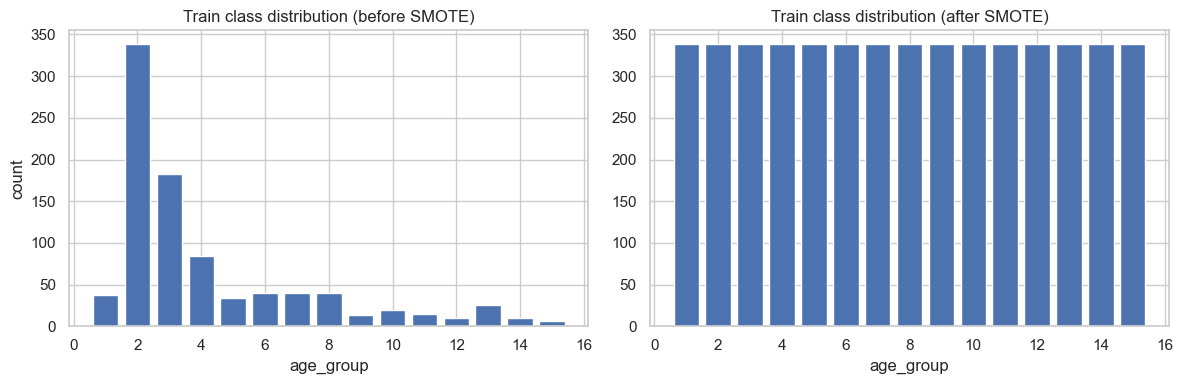

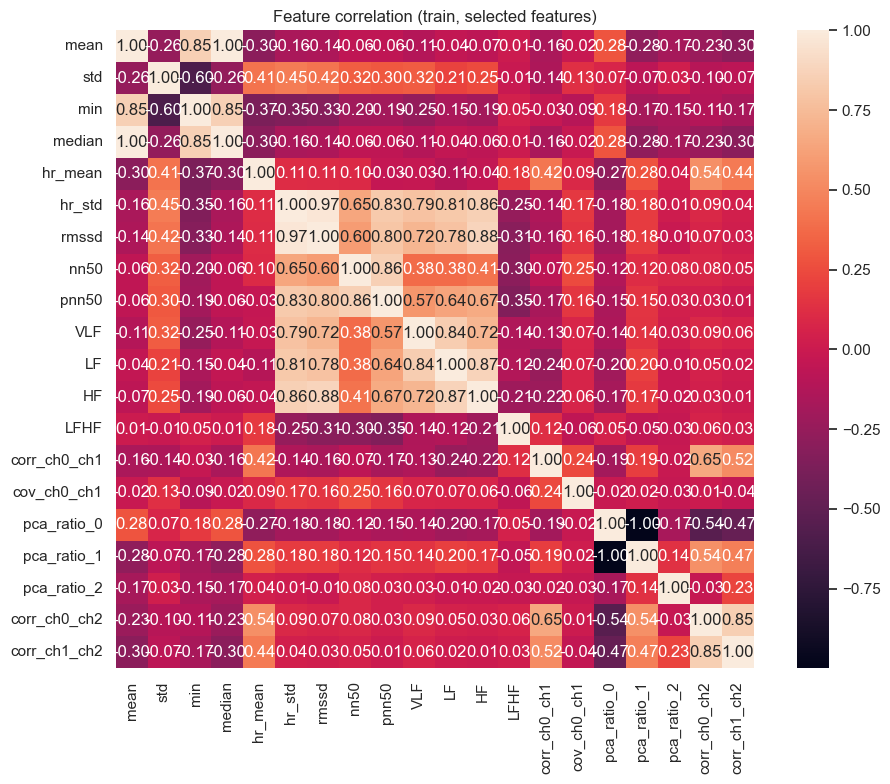

In [10]:
# Generate comprehensive plots
sns.set(style="whitegrid")
plt.rcParams.update({"figure.max_open_warning": 0})

# 1) Class distribution before / after SMOTE
fig1, ax1 = plt.subplots(1, 2, figsize=(12, 4))
train_counts = Counter(y_train)
res_counts = Counter(y_train_res)
ax1[0].bar(list(train_counts.keys()), list(train_counts.values()))
ax1[0].set_title("Train class distribution (before SMOTE)")
ax1[0].set_xlabel("age_group")
ax1[0].set_ylabel("count")

ax1[1].bar(list(res_counts.keys()), list(res_counts.values()))
ax1[1].set_title("Train class distribution (after SMOTE)")
ax1[1].set_xlabel("age_group")
plt.tight_layout()
fig1.savefig(os.path.join(OUTPUT_DIR, "class_distribution.png"))

# 2) Correlation heatmap for selected features
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))
corr = pd.DataFrame(X_train_res, columns=selected_features).corr()
sns.heatmap(corr, annot=True, fmt=".2f", square=True, ax=ax2)
ax2.set_title("Feature correlation (train, selected features)")
plt.tight_layout()
fig2.savefig(os.path.join(OUTPUT_DIR, "feature_correlation.png"))

print("✅ Class distribution and correlation plots saved")


/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dmytro/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2

✅ Boxplots and learning curve saved


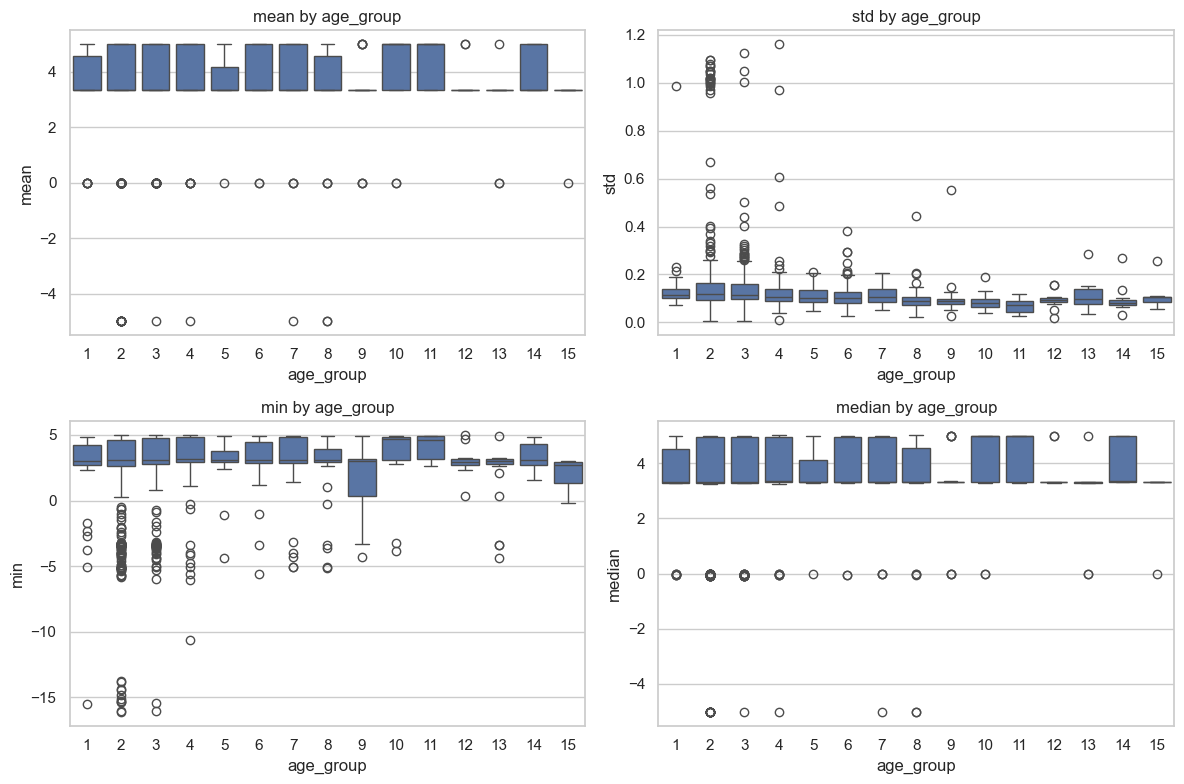

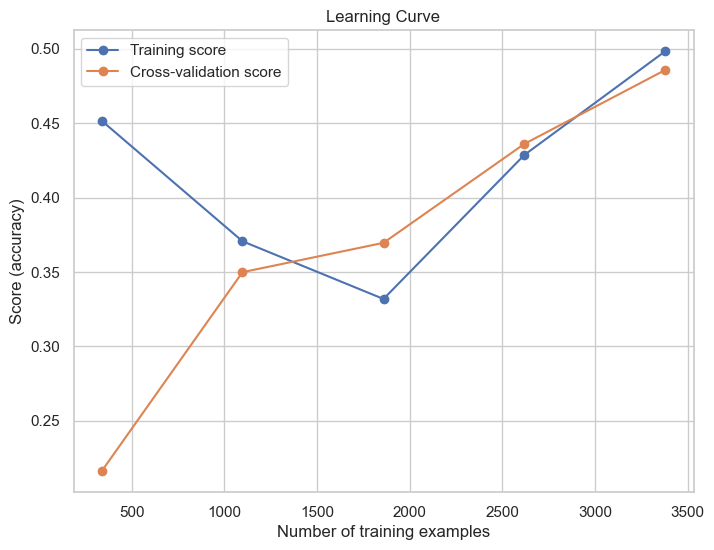

In [11]:
# 3) Boxplots/violinplots of top 4 features by f-score (SelectKBest scores)
# compute column scores from selector (we have selector.scores_ that corresponds to X_all.columns)
# build DataFrame with selected features and y (original)
df_for_plots = pd.concat([X[selected_features].reset_index(drop=True), y.reset_index(drop=True)], axis=1)
top4 = selected_features[:4]  # good heuristic
fig3, axes3 = plt.subplots(2, 2, figsize=(12, 8))
axes3 = axes3.flatten()
for ax, col in zip(axes3, top4):
    sns.boxplot(x="age_group", y=col, data=df_for_plots, ax=ax)
    ax.set_title(f"{col} by age_group")
plt.tight_layout()
fig3.savefig(os.path.join(OUTPUT_DIR, "boxplots_top4.png"))

# 4) Learning curve (train vs cross-val)
train_sizes, train_scores, test_scores = learning_curve(
    best_model, np.vstack([X_train_res_scaled, X_test_scaled])[:len(X_train_res_scaled)], np.concatenate([y_train_res, y_test])[:len(y_train_res)],
    cv=3, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=RANDOM_STATE
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.plot(train_sizes, train_scores_mean, marker="o", label="Training score")
ax4.plot(train_sizes, test_scores_mean, marker="o", label="Cross-validation score")
ax4.set_xlabel("Number of training examples")
ax4.set_ylabel("Score (accuracy)")
ax4.set_title("Learning Curve")
ax4.legend()
ax4.grid(True)
fig4.savefig(os.path.join(OUTPUT_DIR, "learning_curve.png"))

print("✅ Boxplots and learning curve saved")


✅ GridSearch and confusion matrix plots saved


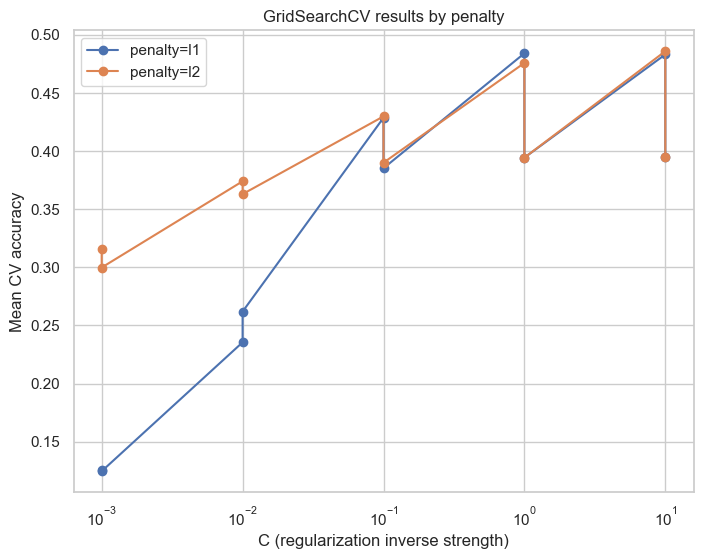

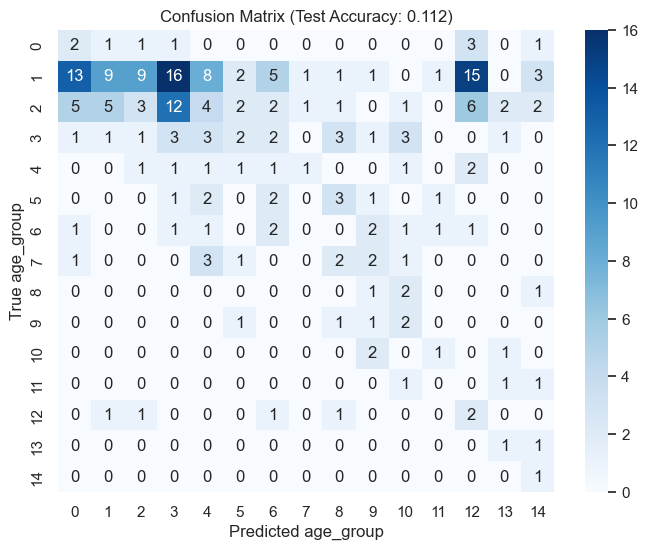

In [12]:
# 5) GridSearch CV results: mean_test_score vs C, separated by penalty
results = pd.DataFrame(grid.cv_results_)
fig5, ax5 = plt.subplots(figsize=(8, 6))
for penalty in results["param_penalty"].unique():
    subset = results[results["param_penalty"] == penalty]
    # some solvers may be incompatible and produce NaN; drop NaNs
    subset = subset.dropna(subset=["param_C", "mean_test_score"])
    ax5.plot(subset["param_C"].astype(float), subset["mean_test_score"], marker="o", label=f"penalty={penalty}")
ax5.set_xscale("log")
ax5.set_xlabel("C (regularization inverse strength)")
ax5.set_ylabel("Mean CV accuracy")
ax5.set_title("GridSearchCV results by penalty")
ax5.legend()
ax5.grid(True)
fig5.savefig(os.path.join(OUTPUT_DIR, "gridsearch_results.png"))

# 6) Confusion matrix heatmap
fig6, ax6 = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax6)
ax6.set_xlabel("Predicted age_group")
ax6.set_ylabel("True age_group")
ax6.set_title(f"Confusion Matrix (Test Accuracy: {acc:.3f})")
fig6.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))

print("✅ GridSearch and confusion matrix plots saved")


✅ Feature importance plot saved


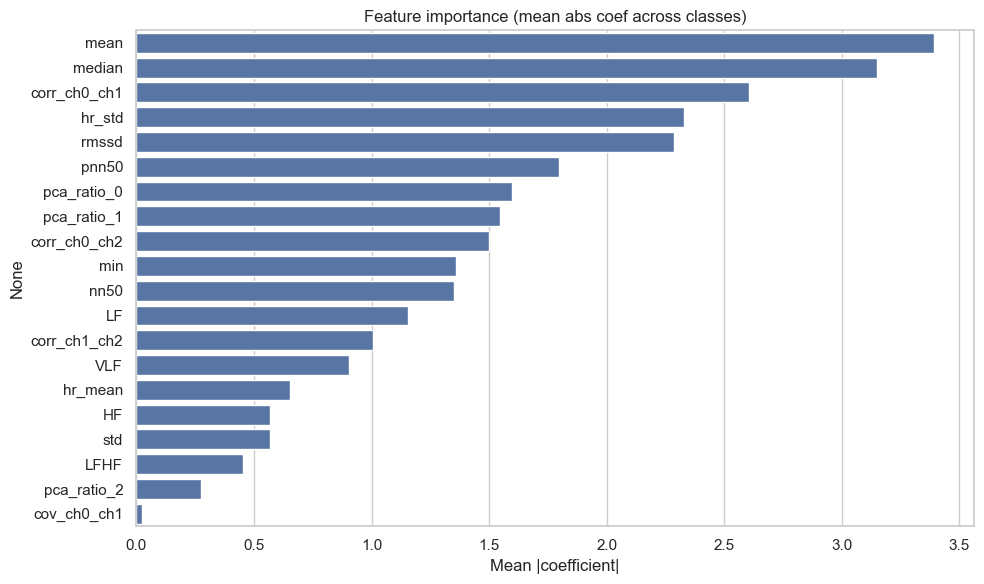

In [13]:
# 7) Feature importance: mean absolute coefficient across classes (for multiclass LR)
coefs = best_model.coef_
# if binary, coefs is shape (1, n_features), else (n_classes, n_features)
mean_abs_coef = np.mean(np.abs(coefs), axis=0)
feat_imp = pd.Series(mean_abs_coef, index=selected_features).sort_values(ascending=False)

fig7, ax7 = plt.subplots(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, ax=ax7)
ax7.set_title("Feature importance (mean abs coef across classes)")
ax7.set_xlabel("Mean |coefficient|")
plt.tight_layout()
fig7.savefig(os.path.join(OUTPUT_DIR, "feature_importance.png"))

print("✅ Feature importance plot saved")


## 7. Visualization and Analysis

Create combined summary plot and save model.


✅ Combined summary plot saved


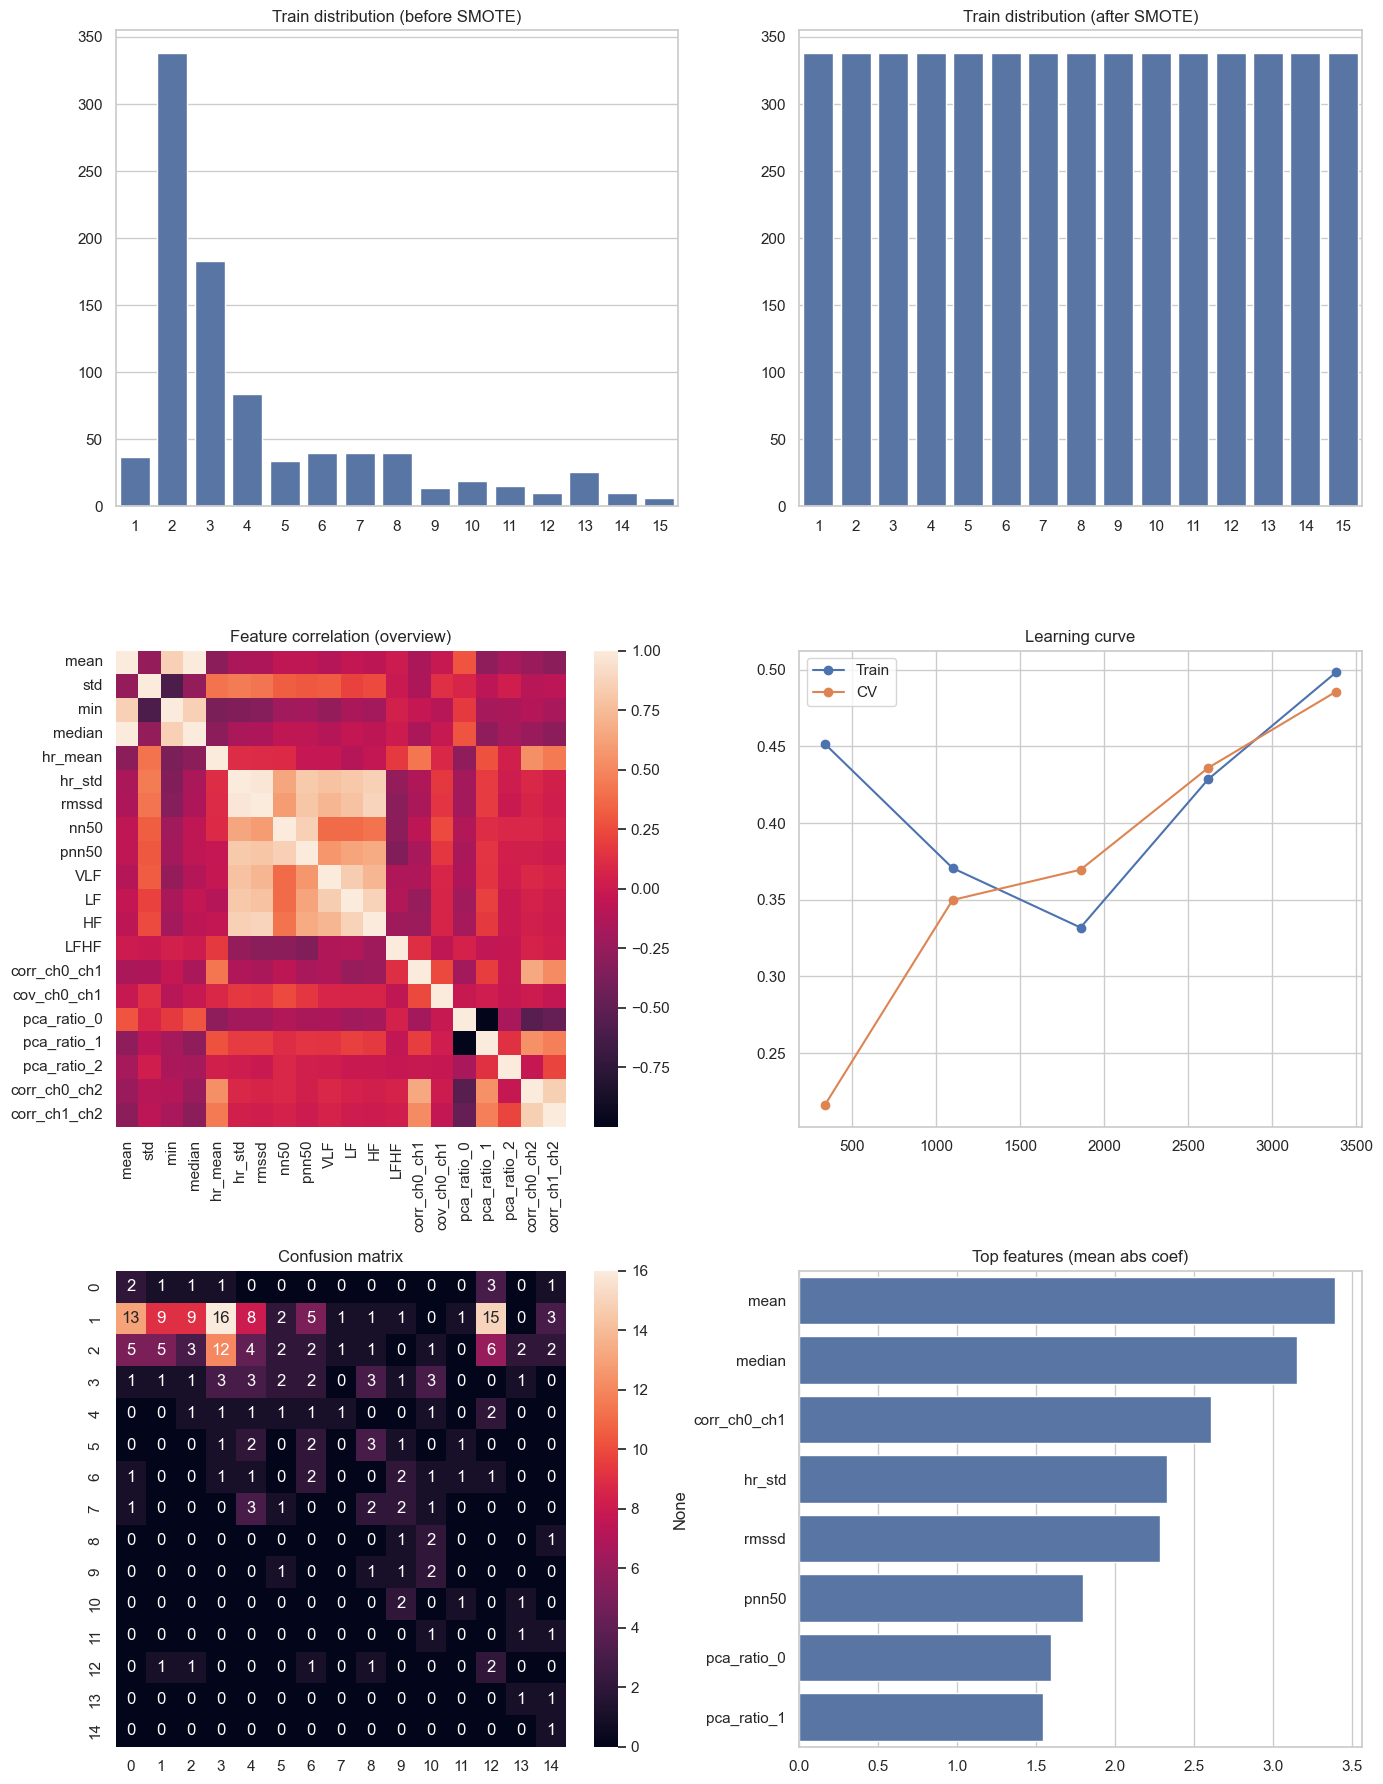

In [14]:
# Compose a combined figure with some of these plots for convenience
fig_combined, axs = plt.subplots(3, 2, figsize=(14, 18))
axs = axs.flatten()

# 0: class dist before
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axs[0])
axs[0].set_title("Train distribution (before SMOTE)")

# 1: class dist after
sns.barplot(x=list(res_counts.keys()), y=list(res_counts.values()), ax=axs[1])
axs[1].set_title("Train distribution (after SMOTE)")

# 2: correlation heatmap small version
sns.heatmap(corr, annot=False, ax=axs[2])
axs[2].set_title("Feature correlation (overview)")

# 3: learning curve
axs[3].plot(train_sizes, train_scores_mean, marker="o", label="Train")
axs[3].plot(train_sizes, test_scores_mean, marker="o", label="CV")
axs[3].set_title("Learning curve")
axs[3].legend()
axs[3].grid(True)

# 4: confusion matrix
sns.heatmap(cm, annot=True, fmt="d", ax=axs[4])
axs[4].set_title("Confusion matrix")

# 5: top features bar
sns.barplot(x=feat_imp.values[:8], y=feat_imp.index[:8], ax=axs[5])
axs[5].set_title("Top features (mean abs coef)")

plt.tight_layout()
fig_combined.savefig(OUTPUT_PNG)

print("✅ Combined summary plot saved")


In [15]:
# Save selected features and model info for reproducibility
meta = {
    "selected_features": selected_features,
    "best_params": grid.best_params_,
    "best_cv_score": float(grid.best_score_),
    "test_accuracy": float(acc)
}
pd.Series(meta).to_json(os.path.join(OUTPUT_DIR, "model_meta.json"))

# Save model using joblib (optional)
try:
    import joblib
    MODEL_PATH = os.path.join(OUTPUT_DIR, "logreg_model.joblib")
    joblib.dump({"model": best_model, "scaler": scaler, "features": selected_features}, MODEL_PATH)
    print("Saved model to", MODEL_PATH)
except Exception as e:
    print("joblib save skipped:", e)

print("Plots saved to:", OUTPUT_DIR)
print("Combined PNG:", OUTPUT_PNG)

print(f"\n🎉 Linear classification training completed!")
print(f"📁 Results saved to: {OUTPUT_DIR}/")
print("📊 Generated files:")
print("  • class_distribution.png")
print("  • feature_correlation.png")
print("  • boxplots_top4.png")
print("  • learning_curve.png")
print("  • gridsearch_results.png")
print("  • confusion_matrix.png")
print("  • feature_importance.png")
print("  • all_plots.png")
print("  • model_meta.json")
print("  • logreg_model.joblib")

print(f"\n📈 Final Metrics:")
print(f"  • Test Accuracy: {acc:.4f}")
print(f"  • Best CV Score: {grid.best_score_:.4f}")
print(f"  • Best Parameters: {grid.best_params_}")
print(f"  • Selected Features: {len(selected_features)}")
print("Done.")


Saved model to ./ecg_linear_outputs/logreg_model.joblib
Plots saved to: ./ecg_linear_outputs
Combined PNG: ./ecg_linear_outputs/all_plots.png

🎉 Linear classification training completed!
📁 Results saved to: ./ecg_linear_outputs/
📊 Generated files:
  • class_distribution.png
  • feature_correlation.png
  • boxplots_top4.png
  • learning_curve.png
  • gridsearch_results.png
  • confusion_matrix.png
  • feature_importance.png
  • all_plots.png
  • model_meta.json
  • logreg_model.joblib

📈 Final Metrics:
  • Test Accuracy: 0.1116
  • Best CV Score: 0.4858
  • Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
  • Selected Features: 20
Done.
